# Лабораторная работа 5
Критерии качества. Кривая ошибок. Оценивание качества.

## Инициализация

### Скачивание пакетов

In [ ]:
%pip install scikit-learn
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install category_encoders

### Импорт пакетов

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc, precision_recall_curve, log_loss, roc_auc_score
import matplotlib.pyplot as plt
import warnings

### Убираем предупреждения

In [2]:
warnings.filterwarnings('ignore')

## Часть 1

### Подобрать таблицу данных с несбалансированными классами.

In [4]:
# Загрузим данные
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.Series(data.target, name='target')

# Создадим дисбаланс в данных
for i in range((int)(len(target) / 3)):
    target[3 * i] = 1

# Добавляем колонку target в таблицу с данными (просто мне так удобнее)
df.insert(0, 'target', target)

31

### Решить задачу классификации любым подходящим методом.

In [133]:
# Разбиваем данные на обучающую и контрольную выборки
X, y = df.drop('target', axis=1), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель (в данном случае, Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
y_pred = model.predict(X_test)

## Часть 2

### Вычислить точность, полноту, специфичность.

#### Формула специфичности

Формула как у полноты (recall), но для II-го класса
$$ specificity = \frac {TN} {TN + FP}  = 1 - FPR $$

, где $ FPR $ - False Positive Rate

#### Код

In [134]:
# Функция оценки специфичности
def specificity_score(y_true, y_pred):
    tn = 0
    fp  =0
    for t, p in zip(y_true, y_pred):
        if t == 0 and p == 0:
            tn += 1
        if t == 0 and p == 1:
            fp += 1
    if tn == 0 or fp == 0:
        return 0
    else:
        return tn / (tn + fp)

In [135]:
# Вычисляем метрики (точность, полноту, специфичность)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print(f"Точность: {accuracy:.6f}")
print(f"Полнота: {recall:.6f}")
print(f"Специфичность: {specificity:.6f}")

Точность: 0.815789
Полнота: 0.829545
Специфичность: 0.769231


## Часть 3

### Построить кривую ошибок и найти площадь под ней. Построить для сравнения кривую "точность-полнота".

#### Теория

Область под кривой **ROC (Receiver Operating Characteristic)** или **ROC AUC (Area Under the ROC Curve)** - это метрика, которая используется для оценки качества бинарной классификации. Кривая **ROC** отображает отношение между **чувствительностью (True Positive Rate)** и **специфичностью (1 - False Positive Rate)** для различных значений порога классификации.

Когда вы строите ROC-кривую, вы получаете график, где по оси X откладывается **False Positive Rate (FPR)**, а по оси Y - **True Positive Rate (TPR)**. **AUC ROC** представляет собой площадь под этой кривой. Чем выше **AUC ROC**, тем лучше модель способна различать между классами.

Значения **AUC ROC** могут варьироваться от 0 до 1:

- **0.5:** случайное предсказание (модель не лучше случайного угадывания).
- **Меньше 0.5:** модель хуже случайного угадывания (может быть инвертирована для улучшения).
- **Больше 0.5:** модель лучше случайного угадывания.

Таким образом, **ROC AUC** предоставляет общую характеристику производительности модели классификации, учитывая ее способность различать между положительными и отрицательными классами при различных уровнях порога. Высокое значение **AUC ROC** указывает на хорошую производительность модели, особенно в случае сбалансированных классов.

#### Строим ROC AUC

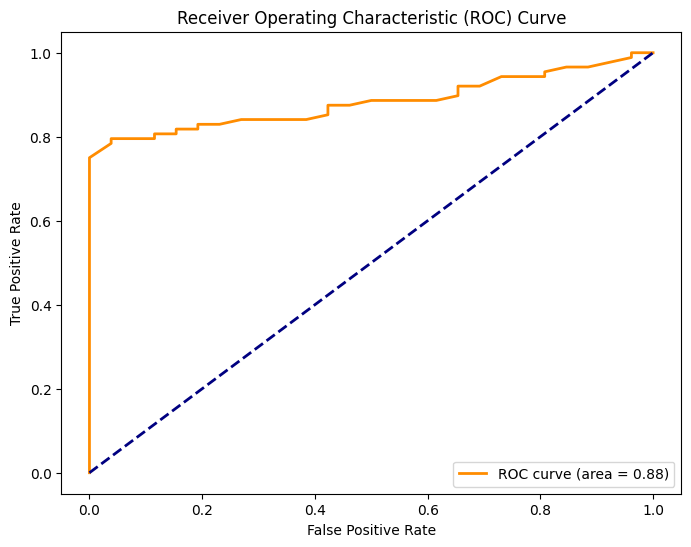

In [136]:
# ROC-кривая и AUC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Построим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Строим Precision Recall Curve

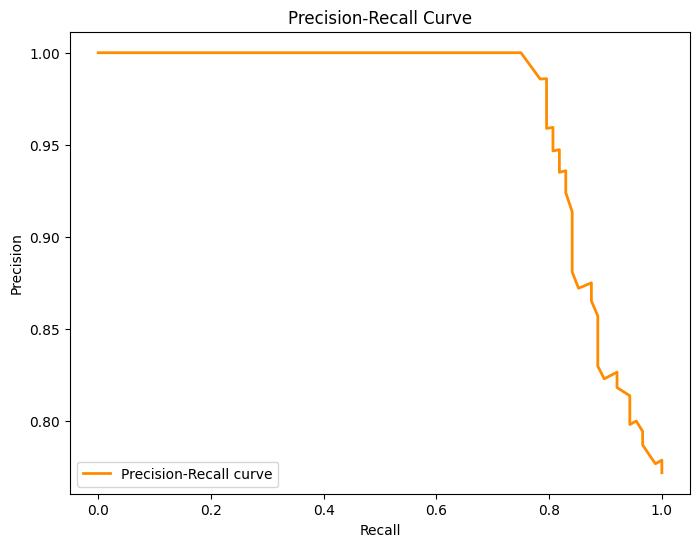

In [137]:
# Кривая "точность-полнота"
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

# Построим кривую "точность-полнота"
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Часть 4

### Разбить данные на обучающую и контрольную выборки.

In [138]:
# Раз уж требуется опять это сделать, то почему бы и нет
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Построить ROC-кривую для каждой из подвыборок.

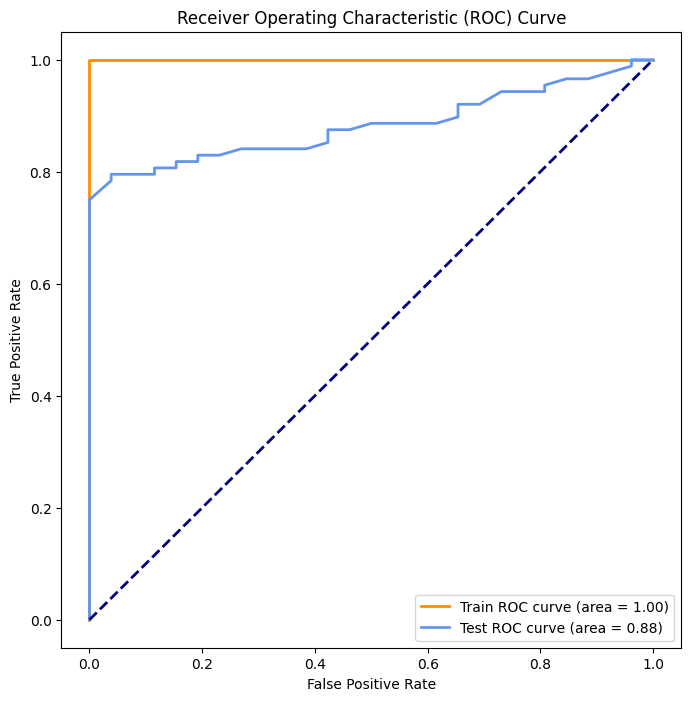

In [139]:
# Обучаем модель (у нас это Random Forest)
model.fit(X_train, y_train)

# Получение вероятностей принадлежности к классу 1 для обучающей выборки
y_train_prob = model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Получение вероятностей принадлежности к классу 1 для контрольной выборки
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Построение ROC-кривых
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Построить ROC-кривую на основе кроссвалидации.

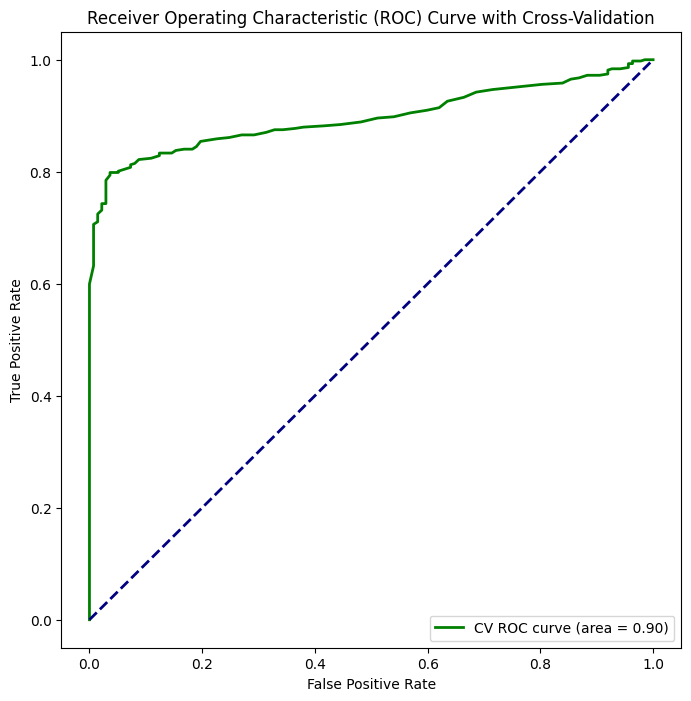

In [140]:
# Получение вероятностей принадлежности к классу 1 с использованием кросс-валидации
y_cv_prob = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]
fpr_cv, tpr_cv, _ = roc_curve(y, y_cv_prob)
roc_auc_cv = auc(fpr_cv, tpr_cv)

# Построение ROC-кривой на основе кросс-валидации
plt.figure(figsize=(8, 8))
plt.plot(fpr_cv, tpr_cv, color='green', lw=2, label=f'CV ROC curve (area = {roc_auc_cv:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Cross-Validation')
plt.legend(loc='lower right')
plt.show()

## Часть 5

### Теория

#### Logaritmic Loss

**Logarithmic Loss (Log Loss)**, представляет собой метрику, используемую для измерения производительности моделей классификации, особенно в задачах с вероятностными прогнозами. Эта метрика оценивает, насколько хорошо распределение вероятностей, предсказанных моделью, соответствует фактическим меткам классов.

Для бинарной классификации **Log Loss** выражается формулой:

$$ Log Loss = - \frac {1} {N} \sum_{i=1}^n (y_i log(p_i) + (1 - y_i) log(1 - p_i)) $$
, где:

- $ N $ - количество примеров в выборке,
- $ y_i $ - фактическая метка класса для примера $ i $ (0 или 1),
- $ p_i $ - вероятность, предсказанная моделью, что пример $ i $ принадлежит к классу 1.

Интерпретация:

Чем меньше **Log Loss**, тем лучше. Оптимальное значение **Log Loss** равно 0, что означает идеальное соответствие предсказанных вероятностей фактическим меткам.

**Log Loss** штрафует модели за уверенные, но неверные предсказания, поскольку ошибка увеличивается экспоненциально с отклонением предсказанной вероятности от фактической метки.

**Log Loss** часто используется в задачах, где важна не только точность предсказаний, но и уверенность модели в своих прогнозах.

#### Кратко об AdaBoost

**AdaBoost (Adaptive Boosting)** обучает последовательность слабых моделей, каждая из которых фокусируется на тех обучающих примерах, которые предыдущие модели классифицировали неправильно, и веса примеров корректируются для создания ансамбля, где более важные примеры получают больший вес, что улучшает обобщающую способность модели.

### Исследовать влияние выбора критерия обучения на AUC на примере AdaBoost и GradientBoosting.

In [143]:
# Разбиение данных на обучающую и контрольную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей с разными критериями
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME')
gb_model = GradientBoostingClassifier(n_estimators=50, random_state=42, criterion='friedman_mse')

# Обучение моделей
ada_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Предсказания вероятностей для вычисления AUC
ada_prob = ada_model.predict_proba(X_test)[:, 1]
gb_prob = gb_model.predict_proba(X_test)[:, 1]

# Вычисление AUC и log loss для каждой модели
auc_ada = roc_auc_score(y_test, ada_prob)
log_loss_ada = log_loss(y_test, ada_prob)

auc_gb = roc_auc_score(y_test, gb_prob)
log_loss_gb = log_loss(y_test, gb_prob)

# Вывод результатов
print(f'         AdaBoost AUC: {auc_ada:.6f}, Log Loss: {log_loss_ada:.6f}')
print(f'Gradient Boosting AUC: {auc_gb:.6f}, Log Loss: {log_loss_gb:.6f}')

         AdaBoost AUC: 0.852273, Log Loss: 0.492572
Gradient Boosting AUC: 0.875437, Log Loss: 0.372641
